# Training and evaluation of a neural network

In [131]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

## Define the network architecture

### Define the neural network

In [132]:
def convert_to_tensor(data: DataFrame):   
    inputs = torch.tensor(data.drop("emotion", axis=1).to_numpy(dtype=np.float32))
    index2label = [label for label in data["emotion"].unique()]
    label2index = {label: index for index, label in enumerate(index2label)}
    labels = torch.tensor([label2index[label] for label in data["emotion"]], dtype=torch.long)
    return list(zip(inputs, labels))

In [133]:
class EmotionClassifierNN(nn.Module):
    def __init__(self, n_features:int = 20, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(n_features, 45),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(45, 45),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(45, 45),
            nn.ReLU(),
            nn.Linear(45, 45),
            nn.ReLU(),
            nn.Linear(45, 4)
        )
    
    def forward(self, input):
        return self.net(input)

### Train the neural network

In [134]:
def train_nn(train_df: DataFrame, epochs: int = 100, batch_size: int = 256, learning_rate: float = 0.5) -> EmotionClassifierNN:    
    nn_model = EmotionClassifierNN(len(train_df.columns) - 1)

    train_data = convert_to_tensor(train_df)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate)

    losses_per_epoch = []
    acc_per_epoch = []
    for epoch in range(epochs):
        losses = []
        correct_preds = 0
        for inputs, labels in train_loader:
            output = nn_model(inputs)
            optimizer.zero_grad()
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            correct_preds += torch.sum(torch.argmax(output, dim=1) == labels)
            losses.append(loss.item())
        print(f"Epoch {epoch+1}: loss: {np.mean(losses)}, accuracy: {correct_preds / len(train_data)}")
        acc_per_epoch.append(correct_preds / len(train_data))
        losses_per_epoch.append(np.mean(losses))

    plt.plot(range(epochs), losses_per_epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(range(epochs), acc_per_epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    return nn_model

### Evaluate the neural network

In [135]:
def evaluate_nn(nn_model: EmotionClassifierNN, train_df: DataFrame, test_df: DataFrame):   
    train_data = convert_to_tensor(train_df)
    test_data = convert_to_tensor(test_df)

    emotions = [label for label in train_df["emotion"].unique()]

    correct_pred_train = {emotion: 0 for emotion in emotions}
    total_pred_train = {emotion: 0 for emotion in emotions}
    correct_pred_test = {emotion: 0 for emotion in emotions}
    total_pred_test = {emotion: 0 for emotion in emotions}

    with torch.no_grad():
        for inputs, labels in train_data:
            output = nn_model(inputs)
            _, predicted = torch.max(output, 0)
            total_pred_train[emotions[labels]] += 1
            if predicted == labels:
                correct_pred_train[emotions[labels]] += 1

    with torch.no_grad():
        for inputs, labels in test_data:
            output = nn_model(inputs)
            _, predicted = torch.max(output, 0)
            total_pred_test[emotions[labels]] += 1
            if predicted == labels:
                correct_pred_test[emotions[labels]] += 1

    for emotion in emotions:
        # Calculate the train and test data accuracy for the current emotion
        train_accuracy = correct_pred_train[emotion] / total_pred_train[emotion]
        test_accuracy = correct_pred_test[emotion] / total_pred_test[emotion]

        # Print the accuracies with improved formatting
        print(f"Accuracy for {emotion}:")
        print(f"\tTrain data: {train_accuracy:.2f}")
        print(f"\tTest data: {test_accuracy:.2f}")

    # Calculate the total train and test data accuracy
    total_train_accuracy = sum(correct_pred_train.values()) / sum(total_pred_train.values())
    total_test_accuracy = sum(correct_pred_test.values()) / sum(total_pred_test.values())

    # Print the total accuracies with improved formatting
    print("Total accuracy:")
    print(f"\tTrain data: {total_train_accuracy:.2f}")
    print(f"\tTest data: {total_test_accuracy:.2f}")

## Handle the dataset with pca

In [136]:
train_df_w_pca = pd.read_csv("train.csv")
test_df_w_pca = pd.read_csv("test.csv")

Epoch 1: loss: 1.2680013305262516, accuracy: 0.3978978991508484
Epoch 2: loss: 1.0737578398302983, accuracy: 0.5433290600776672
Epoch 3: loss: 1.0333996101429588, accuracy: 0.5639210343360901
Epoch 4: loss: 1.0096806287765503, accuracy: 0.5722865462303162
Epoch 5: loss: 0.9875184109336451, accuracy: 0.5875160694122314
Epoch 6: loss: 0.9752397568602311, accuracy: 0.592020571231842
Epoch 7: loss: 0.9679851563353288, accuracy: 0.5928785800933838
Epoch 8: loss: 0.9663057421383104, accuracy: 0.5928785800933838
Epoch 9: loss: 0.9521248873911405, accuracy: 0.5937365889549255
Epoch 10: loss: 0.9630836185656095, accuracy: 0.5941656231880188
Epoch 11: loss: 0.95748286811929, accuracy: 0.5945945978164673
Epoch 12: loss: 0.9470129044432389, accuracy: 0.599742591381073
Epoch 13: loss: 0.9594645908004359, accuracy: 0.5984556078910828
Epoch 14: loss: 0.9619076534321434, accuracy: 0.597597599029541
Epoch 15: loss: 0.9582846070590773, accuracy: 0.5990990996360779
Epoch 16: loss: 0.9483349950690019, acc

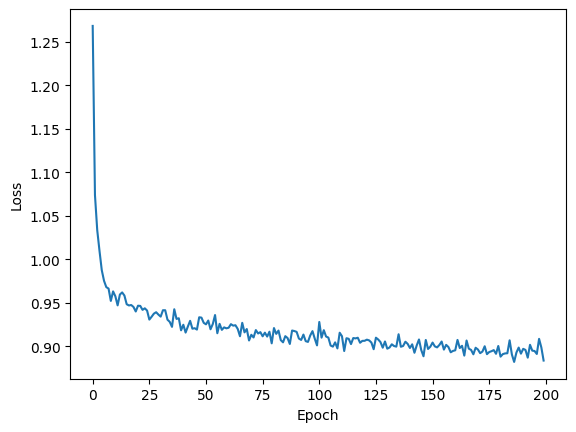

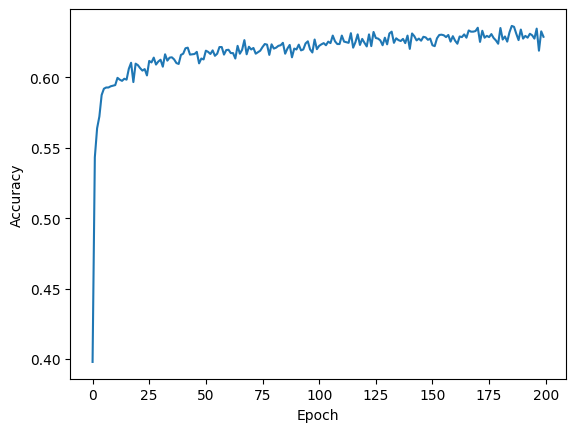

In [137]:
nn_model = train_nn(train_df_w_pca, epochs=200, batch_size=256, learning_rate=0.5)

In [138]:
evaluate_nn(nn_model, train_df_w_pca, test_df_w_pca)

Accuracy for happy:
	Train data: 0.87
	Test data: 0.88
Accuracy for neutral:
	Train data: 0.81
	Test data: 0.45
Accuracy for angry:
	Train data: 0.33
	Test data: 0.01
Accuracy for sad:
	Train data: 0.19
	Test data: 0.19
Total accuracy:
	Train data: 0.63
	Test data: 0.44


## Handle the dataset without pca

In [139]:
train_df_wo_pca = pd.read_csv("train_wo_pca.csv")
test_df_wo_pca = pd.read_csv("test_wo_pca.csv")

Epoch 1: loss: 1.3292955913041766, accuracy: 0.36829686164855957
Epoch 2: loss: 1.1028316742495488, accuracy: 0.5289575457572937
Epoch 3: loss: 1.0294137659825777, accuracy: 0.5510510802268982
Epoch 4: loss: 1.0360620774720843, accuracy: 0.5615615844726562
Epoch 5: loss: 0.9981294054734079, accuracy: 0.5840840935707092
Epoch 6: loss: 0.9809382463756361, accuracy: 0.5915915966033936
Epoch 7: loss: 0.9651720304238168, accuracy: 0.5969541072845459
Epoch 8: loss: 0.9617747978160256, accuracy: 0.5935220718383789
Epoch 9: loss: 0.9644663114296762, accuracy: 0.5969541072845459
Epoch 10: loss: 0.9529783882592854, accuracy: 0.5969541072845459
Epoch 11: loss: 0.942707475863005, accuracy: 0.6033890843391418
Epoch 12: loss: 0.9380321879135934, accuracy: 0.6014586091041565
Epoch 13: loss: 0.9361866681199325, accuracy: 0.610253095626831
Epoch 14: loss: 0.9352638439128274, accuracy: 0.607464611530304
Epoch 15: loss: 0.9363054037094116, accuracy: 0.6055340766906738
Epoch 16: loss: 0.9304058959609584, 

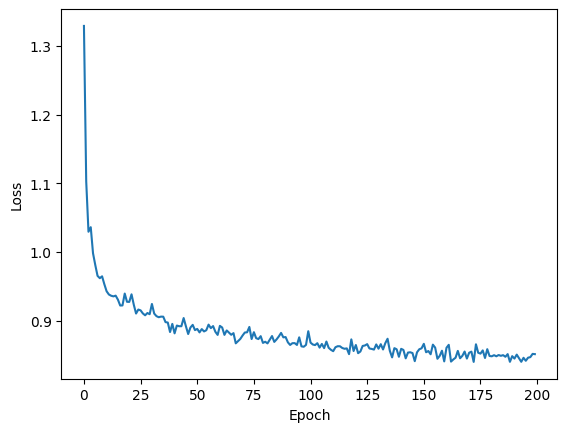

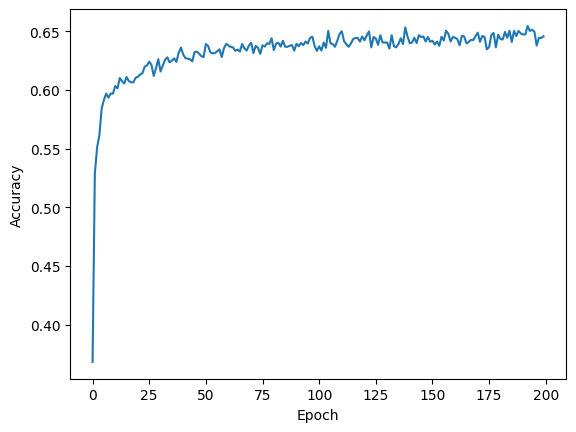

In [140]:
nn_model = train_nn(train_df_wo_pca, epochs=200, batch_size=256, learning_rate=0.5)

In [141]:
evaluate_nn(nn_model, train_df_wo_pca, test_df_wo_pca)

Accuracy for happy:
	Train data: 0.86
	Test data: 0.85
Accuracy for neutral:
	Train data: 0.66
	Test data: 0.28
Accuracy for angry:
	Train data: 0.43
	Test data: 0.06
Accuracy for sad:
	Train data: 0.40
	Test data: 0.35
Total accuracy:
	Train data: 0.64
	Test data: 0.44
